<a href="https://colab.research.google.com/github/patelkirtan29/demo/blob/main/model_trainer_with_less_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import xml.etree.ElementTree as ET
from sklearn import preprocessing
path = r"/content/drive/MyDrive/Phd/Dataset/Open_access_images-20220524T145256Z-001/Open_access_images/"
scores=[]
fnames=[]
for file in os.listdir(path):
    if file.endswith(".xml"):
        full_file = os.path.abspath(os.path.join(path,file))
        tree = ET.parse(full_file)
        root = tree.getroot()
        fnames.append(file[:-4])
        for tirads in root.iter('tirads'):
            scores.append(tirads.text)
            fnames.append(file[:-4])
le = preprocessing.LabelEncoder()
scc=['None' if v is None else v for v in scores]
le.fit(scc)
yy=le.transform(scc)

In [ ]:
!pip install pyradiomics
import radiomics
import logging
from radiomics import featureextractor
import SimpleITK as sitk
import numpy as np
import os, csv, gc, pickle
import cv2
import matplotlib.pyplot as plt
import os
from matplotlib.path import Path
import xml.etree.ElementTree as ET
import json
import pandas as pd
import six
import time
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
log_file = r'/content/drive/MyDrive/Codes/Open_Access/logfile.txt'
handler = logging.FileHandler(filename=log_file, mode='w')  # overwrites log_files from previous runs. Change mode to 'a' to append.
formatter = logging.Formatter("%(levelname)s:%(name)s: %(message)s")  # format string for log messages
handler.setFormatter(formatter)
radiomics.logger.addHandler(handler)
radiomics.logger.setLevel(logging.DEBUG)
path = r"/content/drive/MyDrive/Data/Open_Access/binary/"
settings = {}
settings['binWidth'] = 25
#settings['force2D'] = True
settings['force2Ddimension'] = 0
settings['maskedKernel']=True
settings['initvalue']=0
settings['kernelRadius']=10
settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = sitk.sitkBSpline
settings['verbose'] = False
settings['voxelBatch']=10000
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
csv_data=[]
c1=1
rows, cols = (300, 61)
cfile=1
csvfeatures=[]
feats = [[]]*cols
# sample_size = 10000  # Define the size of the sample to use
binarysize = 1
binarywithTiradOne = ['396', '388', '389', '332', '326', '287', '349', '260', '266', '312', '323', '273', '276', '280', '274', '250', '245', '254', '235', '241', '234', '222', '223', '256', '239', '240', '230', '262', '213', '226', '237', '232', '229', '238', '124', '196', '210', '175', '208', '138', '249', '253', '120', '200', '169', '181', '188', '149', '152', '163', '199', '161', '132', '133', '189', '182', '136', '146', '183', '139', '140', '157', '165', '173', '147', '159', '117', '104', '84', '96', '97', '106', '145', '158', '150', '116', '92', '99', '87', '63', '75', '60', '58', '77', '71', '64', '69', '114', '59', '72', '1', '62']

tirad5Binary = ['374', '394', '296', '330', '351', '340', '294', '290', '337', '345', '315', '227', '220', '246', '252', '211', '180', '186', '207', '101', '81', '85', '80', '46', '56', '5', '36', '11', '29', '19']
tirad4Binary = ['358', '379', '354', '353', '395', '400', '363', '352', '390', '387', '372', '398', '384', '341', '392', '350', '267', '383', '371', '321', '314', '381', '311', '399', '307', '368', '313', '316', '357', '360', '367', '343', '338', '355', '308', '370', '281', '320', '299', '259', '284', '264', '304', '282', '319', '342', '279', '278', '265', '297', '318', '289', '301', '317', '295', '268', '306', '277', '272', '344', '283', '348', '288', '269', '300', '263', '242', '293']
tirad3Binary = ['375', '376', '382', '373', '346', '309', '347', '334', '380', '366', '292', '25', '31', '16']
tirad2Binary = ['391', '377', '386', '369', '361', '397', '356', '362', '365', '359', '378', '333', '364', '336', '310', '329', '331', '305', '270', '285', '335', '303', '339', '204', '190', '247', '127', '134', '160', '130', '193', '66', '51', '61', '22', '2', '17', '14']
allBinary = tirad5Binary + tirad4Binary + tirad3Binary + tirad2Binary
beningImages = tirad3Binary + tirad2Binary[0:19]
malignantImages = tirad5Binary + tirad4Binary[0:36]
totalImages = beningImages + malignantImages
kbest20 = [33,44,49,51,52,53,56,61,63,65,66,67,69,71,73,79,80,82,85,87]

kbest30 = [24,25,27,28,30,33,35,38,44,49,51,52,53,56,60,61,63,65,66,67,68,69,71,73,77,79,80,82,85,87]

kbest50 = [3,6,11,16,24,25,27,28,29,30,31,33,35,36,38,40,42,43,44,46,49,51,52,53,55,56,57,60,61,62,63,64,65,66,67,68,69,71,72,73,76,77,79,80,82,84,85,86,87,91]

kbest60 = [0,3,6,8,9,11,13,16,19,21,22,24,25,26,27,28,29,30,31,33,35,36,38,40,42,43,44,46,49,51,52,53,55,56,57,60,61,62,63,64,65,66,67,68,69,71,72,73,76,77,79,80,82,83,84,85,86,87,91,92]

for file in os.listdir(path):
    # if cfile == 2:
    #     break
    c = 0
    csvfeaturekeys = []
    csvfeaturevalues = []
    ca1 = 0
    ca2 = 0
    f = open(r"/content/drive/MyDrive/Data/Open_Access/binary/" + file, 'rb')
    fnm = file.split("_")
    fnm = fnm[0]
    if fnm in totalImages:
      print('file --> ',file)
      ft = pickle.load(f)
      f.close()
      c = 0
      c1 = 0
      if len(ft[93]) - len(ft[92]) == 0:
          for ar in ft:
              if c in kbest60 or (c == 93):
                # print(c)
                if(c==93):
                  print(set(ar))
                feats[c1] = np.concatenate([feats[c1], ar])
                c1 = c1 + 1
                c = c + 1
              else:
                c = c + 1
      cfile = cfile + 1
      print('file', binarysize, 'ran')
      binarysize = binarysize + 1
    else:
      continue

# Stack the features
X = np.column_stack(feats[:-1])
y = feats[-1]

X=X[y>0,:]
y=y[y>0]

# to remove the 1 tirad and background from the background
y=y[y>1]
print(set(y))

# Feature selection
# sel1 = SelectKBest(f_regression, k=60)
# sel1.fit(X, y)
# X_selected = sel1.transform(X)

# # Print selected feature indices
# selected_indices = sel1.get_support(indices=True)
# print("Selected feature indices:", selected_indices, len (selected_indices))


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 1104, in emit
    self.flush()
  File "/usr/lib/python3.10/logging/__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 107] Transport endpoint is not connected
Call stack:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asy

file -->  296_5
{1.0, 5.0}
file 1 ran
file -->  294_2
{1.0, 5.0}
file 2 ran
file -->  220_1
{1.0, 5.0}
file 3 ran
file -->  227_2
{1.0, 5.0}
file 4 ran
file -->  227_1
{1.0, 5.0}
file 5 ran
file -->  246_1
{1.0, 5.0}
file 6 ran
file -->  252_1
{1.0, 5.0}
file 7 ran
file -->  211_1
{1.0, 5.0}
file 8 ran
file -->  207_1
{1.0, 5.0}
file 9 ran
file -->  180_1
{1.0, 5.0}
file 10 ran
file -->  186_1
{1.0, 5.0}
file 11 ran
file -->  364_1
{1.0, 2.0}
file 12 ran
file -->  384_1
{1.0, 4.0}
file 13 ran
file -->  381_2
{1.0, 4.0}
file 14 ran
file -->  370_1
{1.0, 4.0}
file 15 ran
file -->  353_2
{1.0, 4.0}
file 16 ran
file -->  383_1
{1.0, 4.0}
file 17 ran
file -->  358_2
{1.0, 4.0}
file 18 ran
file -->  386_1
{1.0, 2.0}
file 19 ran
file -->  394_1
{1.0, 5.0}
file 20 ran
file -->  360_2
{1.0, 4.0}
file 21 ran
file -->  354_1
{1.0, 4.0}
file 22 ran
file -->  85_1
{1.0, 5.0}
file 23 ran
file -->  351_2
{1.0, 5.0}
file 24 ran
file -->  101_1
{1.0, 5.0}
file 25 ran
file -->  85_2
{1.0, 5.0}
file 26 r

In [ ]:

y[(y <= 3)] = 1
y[(y > 3)] = 2
set(y)

{1.0, 2.0}

In [ ]:
X = X[y.nonzero()[0], :]
y = np.pad(y, (0, X.shape[0] - y.shape[0]), 'constant')

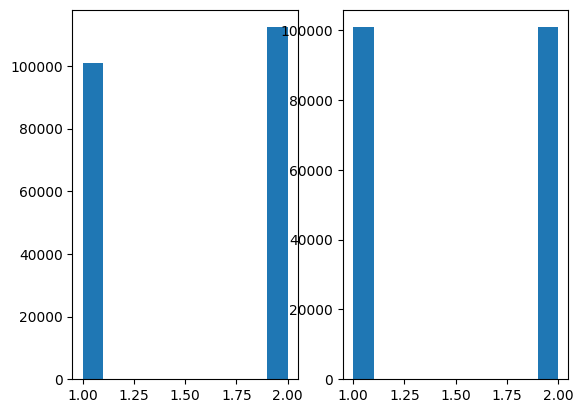

In [ ]:
# # downsampling with imblearn
# from imblearn.under_sampling import RandomUnderSampler
# f,ax=plt.subplots(1,2,sharex=True)
# ax[0].hist(y)
# rus = RandomUnderSampler(sampling_strategy='auto',random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)
# len(y_resampled)
# ax[1].hist(y_resampled)
# plt.show()

In [ ]:
# # import module
# from sklearn.preprocessing import StandardScaler

# # compute required values
# scaler = StandardScaler()
# model = scaler.fit(X_resampled)
# X_resampled_scaled = model.transform(X_resampled)

# # print scaled data
# print(X_resampled_scaled)

[[-0.7330987  -0.06528505  0.78840977 ... -1.47018317 -0.42437051
   0.95854415]
 [-0.80337851 -0.03631556  0.82586759 ... -1.32939972 -0.42437051
   0.95015795]
 [-0.84107207  0.00346344  0.83328112 ... -2.46629444 -0.35436272
   0.80145738]
 ...
 [ 1.31517305  0.51248335 -1.56479958 ...  0.31783518  1.01431357
  -0.92280908]
 [ 0.80904461 -0.4295656  -0.73136314 ...  1.24572786 -0.03947103
  -0.45644659]
 [ 0.9982238  -0.00756226 -1.03492754 ... -0.78807922  0.60011528
  -0.74604317]]


In [ ]:
# # run only if you want to down sample the data
# sample_size = int(X_resampled_scaled.shape[0] * 0.1)
# # Downsample the data
# indices = np.random.choice(X_resampled_scaled.shape[0], size=sample_size, replace=False)
# X_downsampled = X_resampled_scaled[indices]
# y_downsampled = y_resampled[indices]

In [ ]:
# # grid search technique
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42)

# # Instantiate a Random Forest classifier
# clf = RandomForestClassifier()

# # Define the parameter grid for the hyperparameters of interest
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(clf, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_
# score = best_model.score(X_test, y_test)
# print('The score of the optimized model is:', score)


In [ ]:
from sklearn.model_selection import train_test_split
#threshold = 0.5
threshold = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
print('done')
y_pred=clf.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

done
Accuracy: 0.9627962916928656


In [ ]:
f = open('/content/drive/MyDrive/Data/Open_Access/model/randomForestModel_kbest60_binary.pickle', 'wb')
pickle.dump(clf,f)

In [ ]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)
print(cm1)

[[ 98871   7485]
 [  2692 164500]]


In [ ]:
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Accuracy :  0.9627962916928656
Sensitivity :  0.9296231524314567
Specificity :  0.983898751136418


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

from sklearn import svm
svmclf = svm.SVC(kernel='linear',C=1.0)
svmclf.fit(X_train, y_train)
print('Done')
svm_y_pred = svmclf.predict(X_test)
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, svm_y_pred))

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([0.95105305, 0.96999502])